In [2]:
from tradingBot import TradingBot
from neuralNet.sentimentTrainer import SentimentTrainer
from neuralNet.dataLoader import DataLoader
from neuralNet.sentimentPredictor import SentimentPredictor
from webscraping.scrapeTitles import TitleScraper
from datetime import date
from datetime import timedelta
import pandas as pd
import numpy as np
import os
from scipy import stats
import matplotlib.pyplot as plt
import mplcursors
import scipy.interpolate as interpolate

In [3]:

sentimentDf = pd.read_csv('../data/sentimentPredictions.csv')
sentimentDf

,Unnamed: 0,Date,Ticker,Headline,Prediction
0,0,10/20/2020,MRNA,mrna pivots higher possible covid vaccine,NaN
1,1,10/20/2020,MRNA,oct moderna inc mrna ceo stephane bancel sold ...,[[0.69926023]]
2,2,10/20/2020,MRNA,pfizer moderna covid vaccines could take criti...,[[0.0009079]]
3,3,10/20/2020,MRNA,biontech pfizer initiate ph trial covid mrna,NaN
4,4,10/20/2020,MRNA,moderna inc mrna good stock,[[0.88095343]]
5,5,10/20/2020,MRNA,moderna ceo sees eua covid vaccine december,[[0.9911843]]
6,6,10/20/2020,MRNA,biotech covid vaccine frontrunner moderna inc ...,[[0.6270734]]
7,7,10/20/2020,MRNA,ceo stephane bancel sold shares mrna stock ave...,[[0.00022328]]
8,8,10/20/2020,MRNA,moderna mrna pfizer moderna use newer messenge...,[[0.7715949]]
9,9,10/20/2020,MRNA,thawed however mrna vaccine used immediately w...,[[0.00506708]]


In [4]:

train_model = False
scrapes_per_article = 20
# ONLY FOR MICHAELS VSCODE
training_data_dir = '../data/finData/'

In [5]:
# get titlesDF
def getTitleDF(tickers, start, end):
    # tickers = {'NFLX': 'Netflix'}

    df = pd.DataFrame(columns=['Date', 'Ticker', 'Headline'])

    for key in tickers:
    # get 20 titles for each ticker in tickers from the last 2 days
        ts = TitleScraper(key, tickers[key], start, end, scrapes_per_article)

        ts.main()

        frame = pd.DataFrame({'Date': pd.Series([end]).repeat(len                                       (ts.getTitleList())),
            'Ticker': pd.Series(key).repeat(len(ts.getTitleList())),
            'Headline': ts.getTitleList()})

        df = df.append(frame, ignore_index=True)

    return df



In [6]:
start = (date.today() - timedelta(days=30))
end = start
# end  = start + timedelta(days=1)

start = start.strftime('%m/%d/%Y')
end = end.strftime('%m/%d/%Y')

tickersDF = getTitleDF({'NFLX': 'Netflix'}, start,end)

tickersDF

10/25/2020 10/25/2020
clean: Not None
StripTitleList: Not None
10/25/2020 10/25/2020
10/25/2020 10/25/2020
after stripTitleList: Not None
10/25/2020 10/25/2020
clean: Not None
StripTitleList: Not None
10/25/2020 10/25/2020
10/25/2020 10/25/2020
after stripTitleList: Not None


,Date,Ticker,Headline
0,10/25/2020,NFLX,netflix vs tesla earnings comparison
1,10/25/2020,NFLX,top wall street analysts say buy stocks like n...
2,10/25/2020,NFLX,plenty companies released quarterly results we...
3,10/25/2020,NFLX,q nflx guided million paid net additions wall ...
4,10/25/2020,NFLX,example say decide want buy netflix nasdaqnflx...
5,10/25/2020,NFLX,nflx ba bac qqq aapl msft fb
6,10/25/2020,NFLX,mu amd f nio acb gild nflx
7,10/25/2020,NFLX,amazon amzn prime member netflix nflx subscrib...
8,10/25/2020,NFLX,spotify spot saw brand value increase bn psbn ...
9,10/25/2020,NFLX,several large information technology stocks fb...


In [7]:
def predictSentiment(tickersDF):
    dl = DataLoader()

    dl.load_vocab(training_data_dir + 'pos', training_data_dir + 'neg')

    if train_model:
        st = SentimentTrainer(dl.vocab)
        st.train_model(training_data_dir + 'pos', training_data_dir + 'neg')

    sp = SentimentPredictor(dl.vocab)
    sentimentPredictions = sp.predict_sentiment(tickersDF)

    sentimentPredictions.to_csv('../data/sentimentPredictions.csv')

    return sentimentPredictions

predictionDF = predictSentiment(tickersDF)


4609


In [8]:
# figure out how to measure the days sentiment

def listToFloat(x):

    if np.isnan(x):
        return np.nan
    else:
        return float(x[0][0])

def convertToZScores(predictionDF):
    predictionDF['Prediction'] = predictionDF['Prediction'].apply(listToFloat)
    predictionDF = predictionDF.dropna()

    z = stats.zscore(predictionDF['Prediction'])
    predictionDF['z score'] = z
    predictionDF['z score'] = predictionDF[predictionDF['z score'].between(-3,3)]['z score']
    
    return (predictionDF.iloc[0]['Date'], predictionDF['Prediction'].median())


todaysDate, medianSentiment = convertToZScores(predictionDF)

print("The median sentiment on {} was: {:.5f}".format(todaysDate, medianSentiment))

The median sentiment on 10/25/2020 was: 0.99778


In [9]:
def getMonthsSentiment(tickers):

    dates = []
    sentiments = []

    for i in range(30):
        start = (date.today() - timedelta(days=i))
        end = start
        # end  = start + timedelta(days=1)

        start = start.strftime('%m/%d/%Y')
        end = end.strftime('%m/%d/%Y')

        tickersDF = getTitleDF(tickers, start,end)
        predictionDF = predictSentiment(tickersDF)
        d, s = convertToZScores(predictionDF)

        dates.append(d)
        sentiments.append(s)

    return (dates, sentiments)

getMonthsSentiment({'MSFT': 'Microsoft'})


        

11/24/2020 11/24/2020
clean: Not None
StripTitleList: Not None
11/24/2020 11/24/2020
11/24/2020 11/24/2020
after stripTitleList: Not None
11/24/2020 11/24/2020
clean: Not None
StripTitleList: Not None
11/24/2020 11/24/2020
11/24/2020 11/24/2020
after stripTitleList: Not None
4609
11/23/2020 11/23/2020
clean: Not None
StripTitleList: Not None
11/23/2020 11/23/2020
11/23/2020 11/23/2020
after stripTitleList: Not None
11/23/2020 11/23/2020
clean: Not None
StripTitleList: Not None
11/23/2020 11/23/2020
11/23/2020 11/23/2020
after stripTitleList: Not None
11/23/2020 11/23/2020
clean: Not None
StripTitleList: Not None
11/23/2020 11/23/2020
11/23/2020 11/23/2020
after stripTitleList: Not None
11/23/2020 11/23/2020
clean: Not None
StripTitleList: Not None
11/23/2020 11/23/2020
11/23/2020 11/23/2020
after stripTitleList: Not None
4609
11/22/2020 11/22/2020
clean: Not None
StripTitleList: Not None
11/22/2020 11/22/2020
11/22/2020 11/22/2020
after stripTitleList: Not None
11/22/2020 11/22/2020
cl

KeyboardInterrupt: 

In [ ]:
def writeSentiment(df, ticker):
    start = df.iloc[0]['Dates'].replace('/', '-')
    end = df.iloc[-1]['Dates'].replace('/', '-')
    
    df.to_csv('../data/monthSentiment/' + ticker + '.csv')

writeSentiment(df, 'WDAY')

In [ ]:
# MAIN SORT OF
# tickers = [{'WDAY' : 'Workday'}, {'MSFT' : 'Microsoft'}, {'AAPL' : 'Apple'}]

tickers = {'MRNA': 'Moderna'}


dates, sentiments = getMonthsSentiment(tickers)

df = pd.DataFrame({'Dates': dates, 'Median Sentiment': sentiments}).sort_values('Dates')
writeSentiment(df, list(tickers.keys())[0])
    

In [ ]:
def smoothCurve(df):

    x = np.arange(30)
    y = df['Median Sentiment']

    t, c, k = interpolate.splrep(x, y, s=0, k=4)

    N = 100
    xmin, xmax = x.min(), x.max()
    xx = np.linspace(xmin, xmax, N)
    spline = interpolate.BSpline(t, c, k, extrapolate=False)

    return (xx, spline)

    # plt.plot(x, y, 'bo', label='Original points')
    # plt.plot(xx, spline(xx), 'r', label='BSpline')

In [13]:

def plotSentiment(tickerList):
    %pylab


    fig, ax = plt.subplots(1,1)
    xcol = 'date'
    ycol = 'Sentiment'

    for ticker in tickerList:

        df = pd.read_csv('../data/monthSentiment/' + ticker + '.csv')
        # xx, spline = smoothCurve(df)

        # ax.plot(xx, spline(xx))

        ax.plot_date(df['Dates'], df['Median Sentiment'], label=ticker, linestyle='-')

    ax.legend()
    ax.grid(True)
    ax.legend(frameon=False)

    ax.set_title('Reader Sentiment Last 30 Days')
    ax.set_xlabel('Date')
    ax.set_ylabel('Sentiment\n 0: Negative 1: Positive')

    ax.xaxis.set_major_locator(plt.MaxNLocator(5))
    ax.yaxis.set_major_locator(plt.MaxNLocator(6))

    # ax.set_yticklabels(['','Bad', '', 'Neutral','', 'Good', ])

    # plt.gcf().autofmt_xdate()
    mplcursors.cursor(hover=True)
    plt.show()


plotSentiment(['NFLX', 'MSFT', 'AAPL', 'PTON'])

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


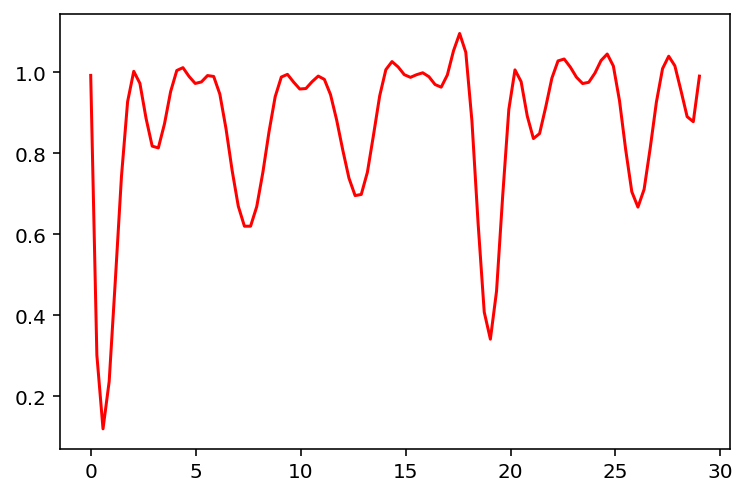

In [14]:
# %matplotlib inline
df = pd.read_csv('../data/monthSentiment/' + 'MSFT' + '.csv')
# x = np.arange(30)

# y = df['Median Sentiment']

# f = interp1d(x,y, kind='linear')

x = np.arange(30)
y = df['Median Sentiment']

t, c, k = interpolate.splrep(x, y, s=0, k=4)

N = 100
xmin, xmax = x.min(), x.max()
xx = np.linspace(xmin, xmax, N)
spline = interpolate.BSpline(t, c, k, extrapolate=False)

# plt.plot(x, y, 'bo', label='Original points')
plt.plot(xx, spline(xx), 'r', label='BSpline')


# plt.plot(x, f(x))
plt.show()